In [ ]:
# default_exp embeddings
# hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

# Node2Vec with Backwards Connection

In this notebook, we will test the Node2Vec algorithm on some simple directed graph and investigate its embedding. Then, we will add backwards connection to the original DeepWalk algorithm and try to apply the algorithm to directed graph to see if it improves the embedding.

We will generate our data using the Directed Stochastic Block Model.

## Source graph

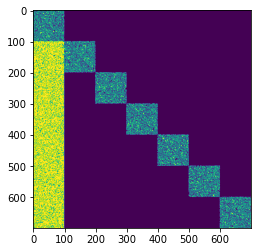

In [ ]:
from directed_graphs.datasets import sink_graph
import torch
import matplotlib.pyplot as plt
dataset = sink_graph(n_points = 700, num_clusters=7)
data = dataset[0]
sparse_A = torch.sparse_coo_tensor(data.edge_index, torch.ones(data.edge_index.shape[1]))
A = sparse_A.to_dense()
plt.imshow(A)

In [ ]:
import sys
sys.argv = ['']

In [ ]:
from torch_geometric.utils import to_networkx
from node2vec import Node2Vec

# the dataset must be converted to networkx format for node2vec
G_nx = to_networkx(data, to_undirected=False)
n_points = data.x.shape[1]
node2vec_model = Node2Vec(G_nx, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec_model.fit(window=10, min_count=1, batch_words=4)
emb = model.wv[[str(i) for i in range(n_points)]]
emb.shape

Computing transition probabilities:   0%|          | 0/700 [00:00<?, ?it/s]

(700, 64)

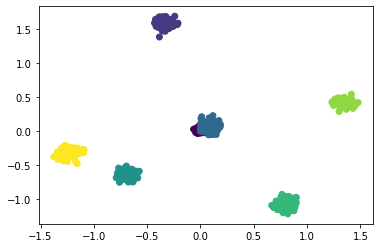

In [ ]:
# plot nodes graph
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
n_clusters = 7
clusters = np.repeat(list(range(n_clusters)),n_points/n_clusters)
pca = PCA(n_components=2)
pca_out= pca.fit_transform(emb)
sc = plt.scatter(pca_out[:, 0], pca_out[:, 1], c=clusters)
plt.show()

DeepWalk seems to be able to learn quite good embeddings for this simple directed graph. Let try combining the code above into one nice function.

In [ ]:
# export
import numpy as np
import matplotlib.pyplot as plt
from karateclub import DeepWalk
from sklearn.decomposition import PCA
from torch_geometric.utils import to_networkx

def deepwalk_and_pca_plot(data,n_clusters,title="",to_undirected=False):
  G_nx = to_networkx(data, to_undirected=to_undirected)
  n_points = data.x.shape[1]
  # Embed nodes
  model = DeepWalk(walk_length=10, dimensions=64, window_size=5)
  model.fit(G_nx)
  embedding = model.get_embedding()
  # Define clusters
  clusters = np.repeat(list(range(n_clusters)),n_points/n_clusters)
  # Visualize
  print("performing PCA...")
  pca = PCA(n_components=2)
  clusters = np.repeat(list(range(n_clusters)),n_points/n_clusters)
  pcs = pca.fit_transform(embedding)
  plt.figure()
  scatter = plt.scatter(pcs[:,0],pcs[:,1],c=clusters)
  plt.legend(handles = scatter.legend_elements()[0], title="Blobs", labels=list(range(n_clusters)))
  plt.suptitle(title)
  return embedding

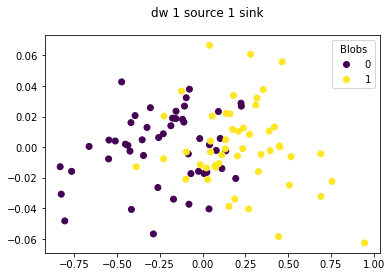

In [ ]:
embedding = deepwalk_and_pca_plot(data, 2, "dw 1 source 1 sink")

In [ ]:
import os
import random
from collections import defaultdict

import gensim
import networkx as nx
import numpy as np
import pkg_resources
from joblib import Parallel, delayed
from tqdm.auto import tqdm


class BackwardsNode2Vec(Node2Vec):
  def __init__(self, graph: nx.Graph, dimensions: int = 128, walk_length: int = 80, num_walks: int = 10, p: float = 1,
                 q: float = 1, weight_key: str = 'weight', workers: int = 1, sampling_strategy: dict = None,
                 quiet: bool = False, temp_folder: str = None, seed: int = None):
    """
    Initiates the Node2Vec object, precomputes walking probabilities and generates the walks.
    :param graph: Input graph
    :param dimensions: Embedding dimensions (default: 128)
    :param walk_length: Number of nodes in each walk (default: 80)
    :param num_walks: Number of walks per node (default: 10)
    :param p: Return hyper parameter (default: 1)
    :param q: Inout parameter (default: 1)
    :param weight_key: On weighted graphs, this is the key for the weight attribute (default: 'weight')
    :param workers: Number of workers for parallel execution (default: 1)
    :param sampling_strategy: Node specific sampling strategies, supports setting node specific 'q', 'p', 'num_walks' and 'walk_length'.
    :param seed: Seed for the random number generator.
    Use these keys exactly. If not set, will use the global ones which were passed on the object initialization
    :param temp_folder: Path to folder with enough space to hold the memory map of self.d_graph (for big graphs); to be passed joblib.Parallel.temp_folder
    """

    self.graph = graph
    self.backward_graph = graph.reverse(copy=True)
    self.dimensions = dimensions
    self.walk_length = walk_length
    self.num_walks = num_walks
    self.p = p
    self.q = q
    self.weight_key = weight_key
    self.workers = workers
    self.quiet = quiet
    self.d_graph = defaultdict(dict)
    self.d_graph_forward = defaultdict(dict)
    self.d_graph_backward = defaultdict(dict)

    if sampling_strategy is None:
        self.sampling_strategy = {}
    else:
        self.sampling_strategy = sampling_strategy

    self.temp_folder, self.require = None, None
    if temp_folder:
        if not os.path.isdir(temp_folder):
            raise NotADirectoryError("temp_folder does not exist or is not a directory. ({})".format(temp_folder))

        self.temp_folder = temp_folder
        self.require = "sharedmem"

    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    self._precompute_probabilities(self.d_graph_forward, self.graph)
    # self._precompute_probabilities(self.d_graph_backward, self.backward_graph)
    # self.d_graph = self.d_graph_forward + self.d_graph_backward
    # self.walks = self._generate_walks()
  
  def _precompute_probabilities(self, d_graph, graph):
    node_generator = graph.nodes() if self.quiet else tqdm(graph.nodes(), desc='Computing transition probabilities')

    for source in node_generator:
      # Init probabilities dict for first travel
      if self.PROBABILITIES_KEY not in d_graph[source]:
        d_graph[source][self.PROBABILITIES_KEY] = dict()

      for current_node in graph.neighbors(source):
        # Init probabilities dict
        if self.PROBABILITIES_KEY not in d_graph[current_node]:
          d_graph[current_node][self.PROBABILITIES_KEY] = dict()
        unnormalized_weights = list()
        d_neighbors = list()
        # Calculate unnormalized weights
        for destination in graph.neighbors(current_node):
          p = self.sampling_strategy[current_node].get(self.P_KEY,
                                                      self.p) if current_node in self.sampling_strategy else self.p
          q = self.sampling_strategy[current_node].get(self.Q_KEY,
                                                      self.q) if current_node in self.sampling_strategy else self.q
          try:
            if graph[current_node][destination].get(self.weight_key):
              weight = graph[current_node][destination].get(self.weight_key)
            else: 
              ## Example : AtlasView({0: {'type': 1, 'weight':0.1}})- when we have edge weight
              edge = list(graph[current_node][destination])[-1]
              weight = graph[current_node][destination][edge].get(self.weight_key)
          except:
            weight = 1 
          if destination == source:  # Backwards probability
            ss_weight = weight * 1 / p
          elif destination in graph[source]:  # If the neighbor is connected to the source
            ss_weight = weight
          else:
            ss_weight = weight * 1 / q
          # Assign the unnormalized sampling strategy weight, normalize during random walk
          unnormalized_weights.append(ss_weight)
          d_neighbors.append(destination)
          
        # Calculate first_travel weights for source
        first_travel_weights = []
        for destination in graph.neighbors(source):
          first_travel_weights.append(graph[source][destination].get(self.weight_key, 1))
        first_travel_weights = np.array(first_travel_weights)
        d_graph[source][self.FIRST_TRAVEL_KEY] = first_travel_weights / first_travel_weights.sum()

        # Save neighbors
        d_graph[source][self.NEIGHBORS_KEY] = list(graph.neighbors(source))
        print(d_graph)